Total dataset size: 405
Missing target values: 0
Features kept after removing constant features: ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV', 'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
Selected features after SelectKBest: ['Hb', 'MCH', 'MCHC', 'HCT', 'BP', 'Cholesterol', 'Diabetes', 'Age']
Accuracy: 0.74
ROC AUC Score: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        34
           1       0.82      0.70      0.76        47

    accuracy                           0.74        81
   macro avg       0.74      0.75      0.74        81
weighted avg       0.76      0.74      0.74        81

Predictions saved to predictions.csv

Count of samples by Anemia Severity and Predicted Probability Range:
Probability_Range  1-20%  21-40%  41-60%  61-80%  81-100%
Anemia_Severity                                          
Mild                   0       6       1       2        0
Moderate               0   

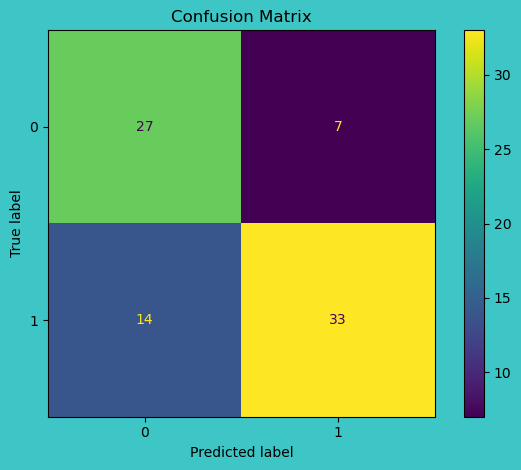

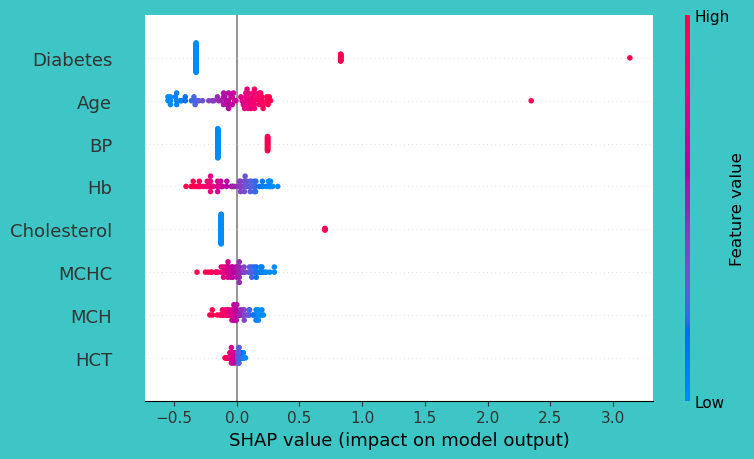

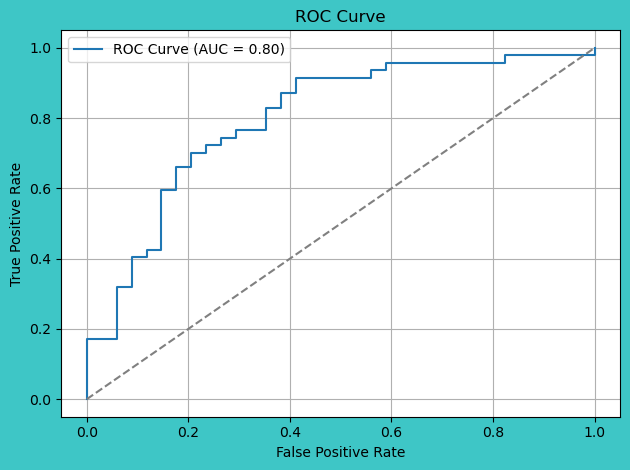

Number of patients with Anemia and Heart Disease: 187


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve


data = pd.read_csv("dataset1_reorder.csv")

data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Define anemia based on gender and age
def is_anemic(row):
    age = row['Age']
    hb = row['Hb']
    gender = row['Gender']  

    if age < 5:
        return hb < 11.0
    elif 5 <= age <= 11:
        return hb < 11.5
    else:  # age >= 12
        if gender == 0:  # Female
            return hb < 12.0
        elif gender == 1:  # Male
            return hb < 13.0
        else:
            return False  # handle unknown gender

data['Anemia'] = data.apply(is_anemic, axis=1)
data['Anemia'] = data['Anemia'].map({True: 'Yes', False: 'No'})

# Anemia severity classification 
def classify_anemia_severity(hb, age, gender):
    # Determine threshold based on age and gender
    if age < 5:
        threshold = 11.0
    elif 5 <= age <= 11:
        threshold = 11.5
    else:
        threshold = 12.0 if gender == 0 else 13.0

    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif hb >= 11.0 and hb < threshold:
        return 'Mild'
    else:
        return 'None'

data['Anemia_Severity'] = data.apply(
    lambda row: classify_anemia_severity(row['Hb'], row['Age'], row['Gender']),
    axis=1
)

# Normalize selected features for modeling
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

print("Total dataset size:", len(data))
print("Missing target values:", data['Heartdisease'].isna().sum())

# Split data 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)

features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]
print("Features kept after removing constant features:", features_kept)

# Feature selection using SelectKBest (ANOVA F-test)
selector = SelectKBest(score_func=f_classif, k=min(8, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)

selected_features = [features_kept[i] for i in selector.get_support(indices=True)]
print("Selected features after SelectKBest:", selected_features)

# Balance training data with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

#  logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, y_train_balanced)

# Predict probabilities for class 1
predicted_proba = model.predict_proba(X_test_selected)[:, 1]

# Convert probabilities to percentages
predicted_proba_percent = predicted_proba * 100

# threshold 
threshold = 0.5
predicted_class = (predicted_proba >= threshold).astype(int)

# Evaluate
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

#  DataFrame for predictions with original indexes
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

#  Cholesterol, Diabetes, BP (convert 1/0 back to Yes/No)
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})

# Add Anemia Severity descriptive label for test set
predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']
predictions_df['Anemia'] = data.loc[X_test.index, 'Anemia']

# bins for predicted probability percentage
bins = [1, 20, 40, 60, 80, 100]
labels = ['1-20%', '21-40%', '41-60%', '61-80%', '81-100%']
predictions_df['Probability_Range'] = pd.cut(predictions_df['Predicted_Probability(%)'], bins=bins, labels=labels, include_lowest=True)

#  predictions
predictions_df.to_csv('predictions.csv')

print("Predictions saved to predictions.csv")

# Show cross-tab of Anemia Severity vs Probability Range
print("\nCount of samples by Anemia Severity and Predicted Probability Range:")
print(pd.crosstab(predictions_df['Anemia_Severity'], predictions_df['Probability_Range']))

# Print training/test class distribution for reference
print("Training class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_class)

# Create the display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot and get the figure and axes
fig, ax = plt.subplots()
fig.patch.set_facecolor('#3ec6c6')   
ax.set_facecolor('#3ec6c6')         

disp.plot(ax=ax, cmap='viridis')       
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


explainer = shap.Explainer(model, X_train_balanced)
shap_values = explainer(X_test_selected)

# Generate SHAP summary plot
shap.summary_plot(shap_values, features=X_test_selected, feature_names=selected_features, show=False)


fig = plt.gcf()
ax = plt.gca()
fig.patch.set_facecolor('#3ec6c6')  
ax.set_facecolor('white')         


plt.tight_layout()
plt.show()



predictions_df['Anemia'] = predictions_df['Anemia'].astype(bool)
predictions_df['Anemia'] = predictions_df['Anemia'].map({'True': True, 'False': False})

fpr, tpr, _ = roc_curve(y_test, predicted_proba)


plt.figure(facecolor='#3ec6c6')  
ax = plt.gca()
ax.set_facecolor('white')  

# Plot ROC Curve
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Count patients with Anemia and Heart Disease
anemia_and_hd = data[(data['Anemia'] == 'Yes') & (data['Heartdisease'] == 1)]
count_anemia_and_hd = anemia_and_hd.shape[0]

print(f"Number of patients with Anemia and Heart Disease: {count_anemia_and_hd}")


Accuracy: 0.73
ROC AUC Score: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.69        34
           1       0.79      0.72      0.76        47

    accuracy                           0.73        81
   macro avg       0.72      0.73      0.72        81
weighted avg       0.73      0.73      0.73        81

Predictions saved to rf_predictions_nosmoke.csv

Count of samples by Anemia Severity and Predicted Probability Range:
Probability_Range  0-20%  21-40%  41-60%  61-80%  81-100%
Anemia_Severity                                          
Mild                   4       1       0       2        2
Moderate               4       3       9      10       10
None                  15       4       4       5        3
Severe                 0       0       1       4        0


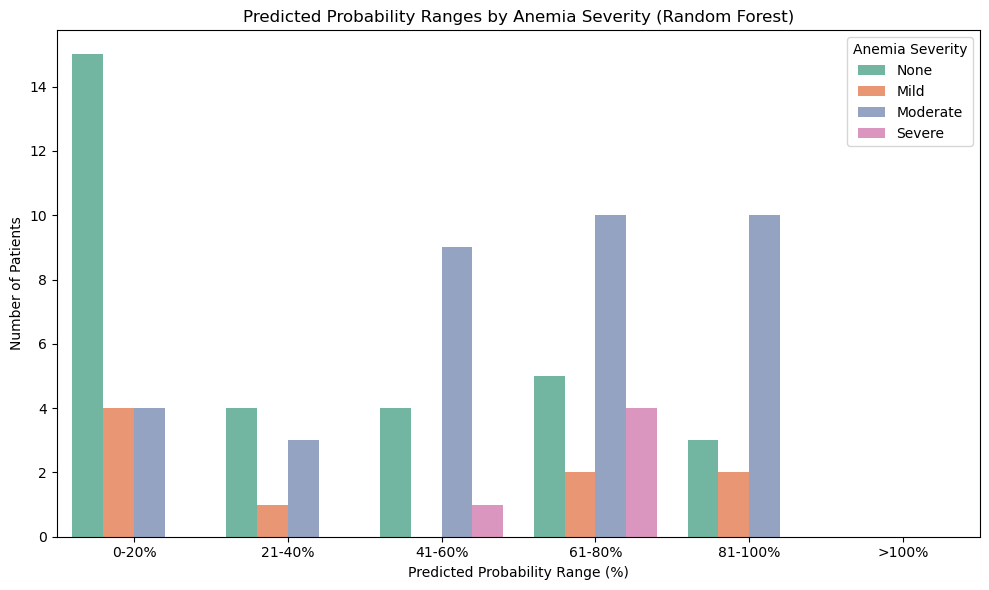

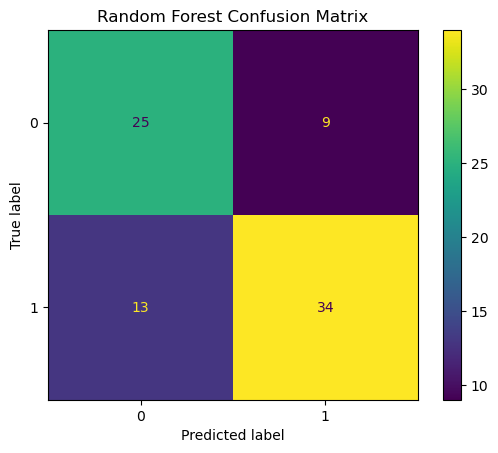


Training class distribution:
 Heartdisease
1    0.57716
0    0.42284
Name: proportion, dtype: float64
Test class distribution:
 Heartdisease
1    0.580247
0    0.419753
Name: proportion, dtype: float64


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


data = pd.read_csv('dataset1_reorder.csv')

# Drop rows with missing target values
data = data.dropna(subset=['Heartdisease'])

# Encode Gender (0=F, 1=M)
if data['Gender'].dtype == object:
    data['Gender'] = LabelEncoder().fit_transform(data['Gender'])

# Map BP, Cholesterol, Diabetes to 0/1
for col in ['BP', 'Cholesterol', 'Diabetes']:
    if data[col].dtype == object:
        data[col] = data[col].map({'Yes': 1, 'No': 0})

# Map Smoking to 0/1 if needed
if 'Smoking' in data.columns:
    if data['Smoking'].dtype == object:
        data['Smoking'] = data['Smoking'].map({'Yes': 1, 'No': 0})
    data['Smoking'] = data['Smoking'].fillna(0)
else:
    print("Warning: 'Smoking' column not found in dataset!")

# Define anemia based on gender
def is_anemic(row):
    if row['Gender'] == 0:
        return row['Hb'] < 12.0
    else:
        return row['Hb'] < 13.0
data['Anemia'] = data.apply(is_anemic, axis=1)

# Anemia severity classification
def classify_anemia_severity(hb, gender):
    threshold = 12.0 if gender == 0 else 13.0
    if hb < 8.0:
        return 'Severe'
    elif 8.0 <= hb <= 10.9:
        return 'Moderate'
    elif 11.0 <= hb < threshold:
        return 'Mild'
    else:
        return 'None'
data['Anemia_Severity'] = data.apply(lambda row: classify_anemia_severity(row['Hb'], row['Gender']), axis=1)

# Feature set
features = ['RBC', 'Hb', 'MCV', 'MCH', 'MCHC', 'HCT', 'RDW-CV',
            'BP', 'Cholesterol', 'Diabetes', 'Age', 'Gender']

# Normalize features
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data[features]), columns=features, index=data.index)

# Prepare features and target
X = data_scaled
y = data['Heartdisease']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Remove constant features
var_thresh = VarianceThreshold(threshold=0)
X_train_var = var_thresh.fit_transform(X_train)
X_test_var = var_thresh.transform(X_test)
features_kept = [feature for feature, keep in zip(features, var_thresh.get_support()) if keep]

# Feature selection
selector = SelectKBest(score_func=f_classif, k=min(8, X_train_var.shape[1]))
X_train_selected = selector.fit_transform(X_train_var, y_train)
X_test_selected = selector.transform(X_test_var)
selected_features = [features_kept[i] for i in selector.get_support(indices=True)]

# SMOTE to balance data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_selected, y_train)

#  Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

# Predict on test data
predicted_class = rf_model.predict(X_test_selected)
predicted_proba = rf_model.predict_proba(X_test_selected)[:, 1]
predicted_proba = np.clip(predicted_proba, 0, 1)
predicted_proba_percent = predicted_proba * 100

# Evaluate
accuracy = accuracy_score(y_test, predicted_class)
roc_auc = roc_auc_score(y_test, predicted_proba)
print(f"Accuracy: {accuracy:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predicted_class, zero_division=0))

# Prepare predictions DataFrame
predictions_df = pd.DataFrame({
    'Predicted_Class': predicted_class,
    'Predicted_Probability(%)': predicted_proba_percent
}, index=X_test.index)

# Add extra columns for display
predictions_df['Cholesterol'] = data.loc[X_test.index, 'Cholesterol'].map({1: 'Yes', 0: 'No'})
predictions_df['Diabetes'] = data.loc[X_test.index, 'Diabetes'].map({1: 'Yes', 0: 'No'})
predictions_df['BP'] = data.loc[X_test.index, 'BP'].map({1: 'Yes', 0: 'No'})

predictions_df['Anemia_Severity'] = data.loc[X_test.index, 'Anemia_Severity']

# Probability bins
bins = [0, 20, 40, 60, 80, 100, 130]
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%', '>100%']
predictions_df['Probability_Range'] = pd.cut(predictions_df['Predicted_Probability(%)'], bins=bins, labels=labels, include_lowest=True)

# Save to CSV
predictions_df.to_csv('rf_predictions_nosmoke.csv')
print("Predictions saved to rf_predictions_nosmoke.csv")

# Display summary table
print("\nCount of samples by Anemia Severity and Predicted Probability Range:")
print(pd.crosstab(predictions_df['Anemia_Severity'], predictions_df['Probability_Range']))

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(
    data=predictions_df,
    x='Probability_Range',
    hue='Anemia_Severity',
    order=labels,
    hue_order=['None', 'Mild', 'Moderate', 'Severe'],
    palette='Set2'
)
plt.title('Predicted Probability Ranges by Anemia Severity (Random Forest)')
plt.xlabel('Predicted Probability Range (%)')
plt.ylabel('Number of Patients')
plt.legend(title='Anemia Severity')
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, predicted_class)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()

# Show class distribution
print("\nTraining class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))
